In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import Tensor
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, \
                         AveragePooling1D, GlobalAveragePooling1D, \
                         Add, BatchNormalization, ReLU, Input
                         
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters



# plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
# %matplotlib widget
# %matplotlib inline

tf.random.set_seed(18)
np.random.seed(48)

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Data Import

In [3]:
with open('_pickles/exp_validation_data.pickle', 'rb') as f:
    ex_val_data = pickle.load(f)
with open('_pickles/exp_validation_labels.pickle', 'rb') as f:
    ex_val_labels = pickle.load(f)
with open('_pickles/exp_validation_trails.pickle', 'rb') as f:
    ex_val_trails = pickle.load(f)

with open('_pickles/exp_val_resample.pickle', 'rb') as f:
    ex_val_resample = pickle.load(f)
with open('_pickles/exp_val_norm_labels.pickle', 'rb') as f:
    ex_val_norm_labels = pickle.load(f)

In [4]:
with open('_pickles/train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)

with open('_pickles/train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)

with open('_pickles/training_labels.pickle', 'rb') as f:
    training_labels = pickle.load(f)

X = np.array(train_resample)
y = training_labels

scalar = MinMaxScaler()
y_norm = scalar.fit_transform(training_labels)

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

(925, 100, 4) (925, 2)
Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


In [29]:
rNet1 = rNet1_history.history
wrNet = wrNet_history.history
vgg = VGG2_act.history

In [30]:
with open('rNet1_history.pickle', 'wb') as f:
    pickle.dump(rNet1, f)
# with open('wrNet_history.pickle', 'wb') as f:
#     pickle.dump(wrNet, f)
# with open('vgg_history.pickle', 'wb') as f:
#     pickle.dump(vgg, f)

#### Other Networks

##### ResNet - v1

In [5]:
def relu_bn(inputs: Tensor) -> Tensor:
    bn = BatchNormalization()(inputs)
    relu = ReLU()(bn)
    return relu

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    # i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(x)
    return j

def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    y = BatchNormalization()(y)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
        
    num_blocks_list = [2, 1, 2]
    t = CNN_block(t, filters = 128)
    for j in range(num_blocks_list[0]):
        t = residual_block(t, filters=128)

    t = Dropout(0.3)(t)

    t = CNN_block(t, filters = 64)
    for j in range(num_blocks_list[1]):
        t = residual_block(t, filters=64)
    
    t = Dropout(0.3)(t)

    t = CNN_block(t, filters = 64)
    for j in range(num_blocks_list[2]):
        t = residual_block(t, filters=64)
    
    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    # t = Dense(units=128, activation='relu')(t)
    t = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['Accuracy']
    )

    return model

rnet1 = create_res_net() # or create_plain_net()
rnet1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 4)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 4)      16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 100, 64)      832         ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 100, 64)     256         ['conv1d[0][0]']             

In [8]:
# timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

# checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.system('mkdir {}'.format(checkpoint_dir))

# # save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

rNet1_history = rnet1.fit(
    x=x_train,
    y=y_train,
    epochs=90,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=32,
    # callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/90
26/26 [==============================] - 5s 58ms/step - loss: 0.4471 - Accuracy: 0.4820 - val_loss: 0.3128 - val_Accuracy: 0.5591
Epoch 2/90
26/26 [==============================] - 1s 40ms/step - loss: 0.1039 - Accuracy: 0.5361 - val_loss: 0.2697 - val_Accuracy: 0.6022
Epoch 3/90
26/26 [==============================] - 1s 40ms/step - loss: 0.0685 - Accuracy: 0.6779 - val_loss: 0.2308 - val_Accuracy: 0.5914
Epoch 4/90
26/26 [==============================] - 1s 40ms/step - loss: 0.0405 - Accuracy: 0.8077 - val_loss: 0.2040 - val_Accuracy: 0.6774
Epoch 5/90
26/26 [==============================] - 1s 40ms/step - loss: 0.0318 - Accuracy: 0.8594 - val_loss: 0.2167 - val_Accuracy: 0.7634
Epoch 6/90
26/26 [==============================] - 1s 42ms/step - loss: 0.0204 - Accuracy: 0.8870 - val_loss: 0.1574 - val_Accuracy: 0.6989
Epoch 7/90
26/26 [==============================] - 1s 43ms/step - loss: 0.0196 - Accuracy: 0.8822 - val_loss: 0.1446 - val_Accuracy: 0.6882
Epoch 8/90
26

In [9]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(rnet1.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(rnet.predict(x_test)))

40.3628022403679

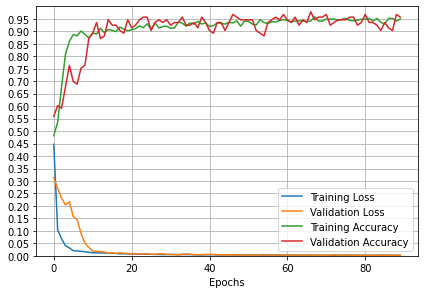

In [10]:
plt.close()
plt.plot(rNet1_history.history['loss'], label='Training Loss')
plt.plot(rNet1_history.history['val_loss'], label='Validation Loss')
plt.plot(rNet1_history.history['Accuracy'], label='Training Accuracy')
plt.plot(rNet1_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))
plt.ylim(bottom=0, top=1)
plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# rnet.save('ResNet-60MSE.h5')

##### Wide ResNet

In [30]:
# Wide ResNet Architecture
# https://arxiv.org/pdf/1605.07146.pdf
#
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(i)
    return j

def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    y = BatchNormalization()(y)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 128
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(inputs)
    t = relu_bn(t)

    #------------------------------------
    num_blocks_list = [1, 1]
    t = CNN_block(t, filters = 128)
    t = residual_block(t, filters=128)
    #------------------------------------
    t = Dropout(0.2)(t)

    t = CNN_block(t, filters = 256)
    t = residual_block(t, filters=256)
    #------------------------------------

    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    # t = Dense(units=96, activation='relu')(t)
    t1 = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t1)
    
    model = Model(inputs, outputs)
    opt = tf.keras.optimizers.Adam(0.001)
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['Accuracy']
    )

    return model

wrnet = create_res_net() # or create_plain_net()
wrnet.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 4)]     0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 100, 128)     1664        ['input_7[0][0]']                
                                                                                                  
 re_lu_30 (ReLU)                (None, 100, 128)     0           ['conv1d_42[0][0]']              
                                                                                                  
 batch_normalization_47 (BatchN  (None, 100, 128)    512         ['re_lu_30[0][0]']               
 ormalization)                                                                              

In [31]:
# timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

# checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.system('mkdir {}'.format(checkpoint_dir))

# # save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

wrNet_history = wrnet.fit(
    x=x_train,
    y=y_train,
    epochs=60,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=32,
    # callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/60
26/26 [==============================] - 3s 49ms/step - loss: 0.5084 - Accuracy: 0.5757 - val_loss: 0.1683 - val_Accuracy: 0.4301
Epoch 2/60
26/26 [==============================] - 1s 36ms/step - loss: 0.1226 - Accuracy: 0.6238 - val_loss: 0.6294 - val_Accuracy: 0.4409
Epoch 3/60
26/26 [==============================] - 1s 36ms/step - loss: 0.0608 - Accuracy: 0.6767 - val_loss: 0.7094 - val_Accuracy: 0.4731
Epoch 4/60
26/26 [==============================] - 1s 38ms/step - loss: 0.0364 - Accuracy: 0.7344 - val_loss: 0.5108 - val_Accuracy: 0.4086
Epoch 5/60
26/26 [==============================] - 1s 39ms/step - loss: 0.0283 - Accuracy: 0.7752 - val_loss: 0.5268 - val_Accuracy: 0.3656
Epoch 6/60
26/26 [==============================] - 1s 40ms/step - loss: 0.0194 - Accuracy: 0.8137 - val_loss: 0.6497 - val_Accuracy: 0.3871
Epoch 7/60
26/26 [==============================] - 1s 40ms/step - loss: 0.0140 - Accuracy: 0.8654 - val_loss: 0.7234 - val_Accuracy: 0.4086
Epoch 8/60
26

In [32]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wrnet.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wrnet.predict(x_test)))

50.381816121212566

In [19]:
wrnet.save(f'wrNet_13_MSE.{int(time.time())}.h5')

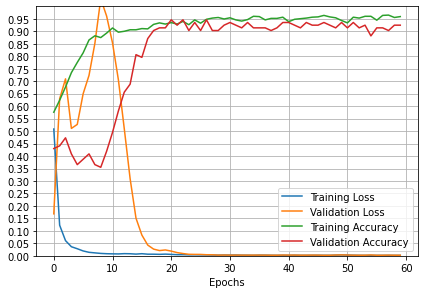

In [33]:
plt.close()
plt.plot(wrNet_history.history['loss'], label='Training Loss')
plt.plot(wrNet_history.history['val_loss'], label='Validation Loss')
plt.plot(wrNet_history.history['Accuracy'], label='Training Accuracy')
plt.plot(wrNet_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))
plt.ylim(bottom=0, top=1)
plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

##### VGG

In [6]:
VGG2 = Sequential()

VGG2.add(Conv1D(filters=64, kernel_size=3, strides=2,activation='relu', input_shape=(100,4), padding='same'))
VGG2.add(Conv1D(filters=64, kernel_size=3, strides=1,activation='relu',padding='valid'))
VGG2.add(Conv1D(filters=64, kernel_size=1, strides=1,activation='relu' ))

VGG2.add(MaxPooling1D(pool_size=2, strides=2))

VGG2.add(Conv1D(filters=128, kernel_size=3, strides=1,activation='relu',padding='valid'))
VGG2.add(Conv1D(filters=128, kernel_size=1, strides=1,activation='relu' ))

VGG2.add(MaxPooling1D(pool_size=2, strides=2))

VGG2.add(Conv1D(filters=256, kernel_size=3, strides=1,activation='relu',padding='valid'))
VGG2.add(Conv1D(filters=256, kernel_size=1, strides=1,activation='relu' ))

VGG2.add(MaxPooling1D(pool_size=2, strides=2))

VGG2.add(Conv1D(filters=256, kernel_size=3, strides=1,activation='relu',padding='valid'))
VGG2.add(Conv1D(filters=384, kernel_size=1, strides=1,activation='relu'))
VGG2.add(Conv1D(filters=100, kernel_size=1, strides=1,activation='relu'))
VGG2.add(MaxPooling1D(pool_size=2, strides=2))

VGG2.add(Flatten())

VGG2.add(Dense(units=2,activation='linear'))

VGG2.summary()

VGG2.compile(loss = 'mse', optimizer = 'Adam', metrics=['Accuracy'])
VGG2_act=VGG2.fit(x_train, y_train, epochs=40, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 50, 64)            832       
                                                                 
 conv1d_15 (Conv1D)          (None, 48, 64)            12352     
                                                                 
 conv1d_16 (Conv1D)          (None, 48, 64)            4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 conv1d_17 (Conv1D)          (None, 22, 128)           24704     
                                                                 
 conv1d_18 (Conv1D)          (None, 22, 128)           16512     
                                                        

In [7]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(VGG2.predict(x_test)), squared=True)

26.453016721681067

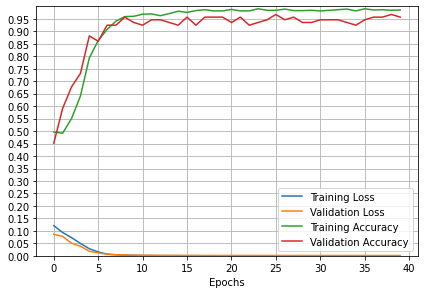

In [8]:
plt.close()
plt.plot(VGG2_act.history['loss'], label='Training Loss')
plt.plot(VGG2_act.history['val_loss'], label='Validation Loss')
plt.plot(VGG2_act.history['Accuracy'], label='Training Accuracy')
plt.plot(VGG2_act.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))
plt.ylim(0, 1)
plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Predict experimental data validation

In [ ]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('Alex3.h5')
# model = tf.keras.models.load_model('model/CNN_val_acc_96_48_MSEperAcc.1642513870.h5')
# model.summary()

In [9]:
y_pred = VGG2.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels

y_pred = scalar.inverse_transform(np.asarray(y_pred))
diff = y_abs-y_pred
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

Absolute Trial 1.0- [205. 200.] Predicted - [234.15683 232.46223] 	Difference - [-29.15682983 -32.4622345 ]
Absolute Trial 2.0- [205. 200.] Predicted - [232.76448 233.13591] 	Difference - [-27.76448059 -33.13591003]
Absolute Trial 3.0- [205. 200.] Predicted - [234.46175 223.41066] 	Difference - [-29.46174622 -23.41065979]
Absolute Trial 4.0- [205. 200.] Predicted - [234.88995 231.8834 ] 	Difference - [-29.88995361 -31.88340759]
Absolute Trial 1.0- [225. 210.] Predicted - [254.66748 258.40576] 	Difference - [-29.66748047 -48.40576172]
Absolute Trial 2.0- [225. 210.] Predicted - [237.88997 248.05151] 	Difference - [-12.88996887 -38.05151367]
Absolute Trial 3.0- [225. 210.] Predicted - [240.98041 251.11476] 	Difference - [-15.98040771 -41.11476135]
Absolute Trial 4.0- [225. 210.] Predicted - [242.67094 252.83586] 	Difference - [-17.67094421 -42.83586121]
Absolute Trial 1.0- [230. 245.] Predicted - [226.90459 246.00522] 	Difference - [ 3.09541321 -1.00521851]
Absolute Trial 2.0- [230. 245.

In [10]:
mean_squared_error(y_abs, y_pred, squared=True)
# mean_absolute_error(y_abs, y_pred)

466.41875991935865